## Estimating Energy Reference Area of Residential Buildings in Switzerland

### Summary

The energy reference area (ERFA) is the sum of all gross floor area above and below ground that requires heating or air conditioning for occupancy. 

This exercise is about exploring a way to estimate ERFA of buildings located in Switzerland by using geo-spatial datasets. The choice of the predictors, gross area, footprint area and number of floors, is based on the study conducted by [Thomas Schluck et al 2019 J. Phys.: Conf. Ser. 1343 012031](https://doi.org/10.1088/1742-6596/1343/1/012031)

### Data Sources

Data about 2200 buildings has been gathered from GeoAdmin API and matched by building id to their respective certification information.

For each building, Minergie certificate data has been requested from https://www.geocat.ch/geonetwork/srv/eng/catalog.search#/metadata/ad60a67c-f0a0-41fa-84f2-20b8565c9da9

Building register information 'swiss_buildings.csv' has been requested via API calls from: https://www.geocat.ch/geonetwork/srv/eng/catalog.search#/metadata/56553efe-4a2c-449d-93ba-cf7edd518d56 and merged with additional information about ERFA for each building taken from https://www.minergie.ch/de/gebaeude/ 

Building footprint geometry data 'building_geometries.gpkg' was obtained from https://data.geo.admin.ch/browser/index.html#/collections/ch.bfe.solarenergie-eignung-fassaden/items/solarenergie-eignung-fassaden 

Since all these datasets are quite large, by using geopandas, osgeo and SQL queries only data for certain buildings was extracted for the purpose of this exercise.

### Disclaimer:
This project contains information taken from https://api3.geo.admin.ch/ and https://www.minergie.ch/de/gebaeude/

I do not own these data. It is open access and available to under these terms: https://www.geo.admin.ch/en/general-terms-of-use-fsdi

In [1]:
import pandas as pd
import geopandas as gpd
from shapely import geometry, ops
from shapely.geometry.polygon import Polygon
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
buildings = pd.read_csv('./datasets/swiss_buildings.csv', sep=',')
buildings.head()

,Id,municipality,address,canton,status,category,class,year,stories,certificate,standard,longitude_ch,latitude_ch,energy,ERFA
0,280075488,Pully,Avenue Charles Ferdinand Ramuz 74,VD,1004,1060,1220.0,2013.0,NaN,VD-560,Minergie,539094.0,151261.0,7513.0,1006
1,280077140,Chavannes-près-Renens,Avenue de la Gare 29,VD,1004,1020,1122.0,2012.0,4.0,VD-794,Minergie,533958.0,153907.0,7520.0,1446
2,280057839,Boussens,Chemin de l'Etang 1b,VD,1004,1020,1110.0,2009.0,2.0,VD-312,Minergie,534672.0,161503.0,7501.0,225
3,280079581,Saint-Sulpice (VD),Route Cantonale 13.3,VD,1004,1060,1265.0,2012.0,NaN,VD-052-ECO,Minergie_Eco,534073.0,152311.0,7580.0,2489
4,280082602,Renens (VD),Rue du Lac 83,VD,1004,1020,1110.0,2013.0,2.0,VD-1408,Minergie,535340.0,152918.0,7501.0,190


In [3]:
buildings.shape

(2287, 15)

The variables 'status', 'category', 'class' and 'energy' are numerical place holders for categorical varialbes. For example 'status 1004' means 'existant' building. All those categories are stored in 'kodes_codes_codici.csv'. This data has been obtained from https://www.housing-stat.ch/de/madd/public.html

In [4]:
# This data has been obtained from https://www.housing-stat.ch/de/madd/public.html
codes = pd.read_csv('./datasets/kodes_codes_codici.csv', sep='\t').set_index('CECODID')
codes.head()

,CMERKM,CODTXTLD,CODTXTKD,CODTXTLF,CODTXTKF,CODTXTLI,CODTXTKI,CEXPDAT
CECODID,,,,,,,,
0,DOFFADR,Nein,Nein,Non,Non,No,No,19.11.2023
0,GSCHUTZR,Nein,Nein,Non,Non,No,No,19.11.2023
0,WKCHE,Nein,Nein,Non,Non,No,No,19.11.2023
0,WMEHRG,Nein,Nein,Non,Non,No,No,19.11.2023
1,DOFFADR,Ja,Ja,Oui,Oui,Sì,Sì,19.11.2023


In [5]:
codes.loc[1004]['CODTXTLD']

'Gebäude bestehend'

In [6]:
pd.DataFrame(codes.loc[1060]).T

,CMERKM,CODTXTLD,CODTXTKD,CODTXTLF,CODTXTKF,CODTXTLI,CODTXTKI,CEXPDAT
1060,GKAT,Gebäude ohne Wohnnutzung,Ohne Wohnnutzung,Bâtiment sans usage d'habitation,Sans usage d'habitation,Edificio ad uso non abitativo,Edificio non abitativo,19.11.2023


"Gebäude ohne Wohnnutzung" means "A building with no residential use"

In [7]:
buildings_status = buildings.groupby('status').apply(lambda x: x.shape[0]).to_dict()
buildings_status

{1001: 1, 1003: 2, 1004: 2284}

In [8]:
buildings_statust_DE = {}
for key in buildings_status:
    buildings_statust_DE[codes.loc[key]['CODTXTLD']] = buildings_status[key]
buildings_statust_DE

{'Gebäude projektiert': 1, 'Gebäude im Bau': 2, 'Gebäude bestehend': 2284}

Translated this means: 

1 Buildings planned ('Gebäude projektiert'), 

2 Buildings under construction ('Gebäude im Bau'), 

2284 Existing buildings ('Gebäude bestehend').

In [9]:
buildings_category = buildings.groupby('category').apply(lambda x: x.shape[0]).to_dict()
buildings_category

{1020: 2001, 1030: 113, 1040: 52, 1060: 120, 1080: 1}

In [10]:
buildings_category_DE = {}
for key in buildings_category:
    buildings_category_DE[codes.loc[key]['CODTXTLD']] = buildings_category[key]
buildings_category_DE

{'Gebäude mit ausschliesslicher Wohnnutzung': 2001,
 'Andere Wohngebäude (Wohngebäude mit Nebennutzung)': 113,
 'Gebäude mit teilweiser Wohnnutzung': 52,
 'Gebäude ohne Wohnnutzung': 120,
 'Sonderbau': 1}

Translated this means:

'Buildings with exclusively residential use': 2001,

'Other residential buildings (residential buildings with secondary use)': 113,

'Buildings with partial residential use': 52,

'Buildings without residential use': 120,

'Special building': 1

In [11]:
buildings_class = buildings.groupby('class').apply(lambda x: x.shape[0]).to_dict()
buildings_class

{1110.0: 1275,
 1121.0: 104,
 1122.0: 735,
 1130.0: 12,
 1211.0: 4,
 1220.0: 26,
 1230.0: 15,
 1242.0: 3,
 1251.0: 22,
 1252.0: 3,
 1261.0: 6,
 1263.0: 26,
 1264.0: 5,
 1265.0: 4,
 1271.0: 1,
 1272.0: 2,
 1274.0: 11}

In [12]:
buildings_class_DE = {}
for key in buildings_class:
    buildings_class_DE[codes.loc[key]['CODTXTLD']] = buildings_class[key]
buildings_class_DE

{'Gebäude mit einer Wohnung': 1275,
 'Gebäude mit zwei  Wohnungen': 104,
 'Gebäude mit drei oder mehr Wohnungen': 735,
 'Wohngebäude für Gemeinschaften': 12,
 'Hotelgebäude': 4,
 'Bürogebäude': 26,
 'Gross-und Einzelhandelsgebäude': 15,
 'Garagengebäude': 3,
 'Industriegebäude': 22,
 'Behälter, Silos und Lagergebäude': 3,
 'Gebäude für Kultur- und Freizeitzwecke': 6,
 'Schul- und Hochschulgebäude, Forschungseinrichtungen': 26,
 'Krankenhäuser und Facheinrichtungen des Gesundheitswesens': 5,
 'Sporthallen': 4,
 'Landwirtschaftliche Betriebsgebäude': 1,
 'Kirchen und sonstige Kultgebäude': 2,
 'Sonstige Hochbauten, anderweitig nicht genannt': 11}

Translated this means:
    
'Building with one apartment': 1275,

'Buildings with two dwellings': 104,

'Buildings with three or more dwellings': 735,

'Residential buildings for communities': 12,

'Hotel buildings': 4,

'Office buildings': 26,

'Wholesale and retail buildings': 15,

'Garage buildings': 3,

'Industrial buildings': 22,

'Tanks, silos and storage buildings': 3,

'Buildings for cultural and leisure purposes': 6,

'School and university buildings, research facilities': 26,

'Hospitals and specialized healthcare facilities': 5,

'Sports halls': 4,

'Agricultural buildings': 1,

'Churches and other religious buildings': 2,

'Other buildings, not elsewhere specified': 11

**To be precise with our analysis, we will focus on:**


Buildings of **status** 'Existing buildings': **1004**

Buildings of **category** 'Buildings with exclusively residential use': **1020**

Buildings of **class** 'Building with one apartment':**1110**, 'Buildings with two dwellings':**1121** and 'Buildings with three or more dwellings':**1122**.

In [13]:
buildings_filtered = buildings[((buildings['status'] == 1004) & \
                                (buildings['category'] == 1020) & \
                               ((buildings['class'] == 1110) | \
                                (buildings['class'] == 1121) | \
                                (buildings['class'] == 1122)))]
buildings_filtered.shape

(1998, 15)

#### Inspect buiding geometry


In [14]:
gdf = gpd.read_file('./datasets/building_geometries.gpkg')
gdf.head()

,GWR_EGID,BEDARF_WARMWASSER,BEDARF_HEIZUNG,geometry
0,190174432,4320,7897,"MULTILINESTRING ((2582844.207 1117600.781, 258..."
1,190174432,4320,7897,"MULTILINESTRING ((2582838.336 1117607.227, 258..."
2,190174432,4320,7897,"MULTILINESTRING ((2582842.786 1117611.283, 258..."
3,190174432,4320,7897,"MULTILINESTRING ((2582841.299 1117612.914, 258..."
4,190174432,4320,7897,"MULTILINESTRING ((2582845.263 1117616.526, 258..."


We can see that rows with the same GWR_EGID belong to one single building.

In [15]:
list(gdf.groupby('GWR_EGID').groups.keys())[101:111]

[582412,
 582607,
 582948,
 583363,
 586353,
 607677,
 610125,
 615010,
 627407,
 627571]

In [16]:
sample_building = gdf.iloc[gdf.groupby('GWR_EGID').groups[607677]]
sample_building

,GWR_EGID,BEDARF_WARMWASSER,BEDARF_HEIZUNG,geometry
575,607677,5174,77033,"MULTILINESTRING ((2630575.531 1269332.087, 263..."
576,607677,5174,77033,"MULTILINESTRING ((2630550.093 1269316.358, 263..."
577,607677,5174,77033,"MULTILINESTRING ((2630542.804 1269328.146, 263..."
578,607677,5174,77033,"MULTILINESTRING ((2630578.972 1269350.511, 263..."
579,607677,1059,15737,"MULTILINESTRING ((2630568.154 1269343.821, 263..."
580,607677,1059,15737,"MULTILINESTRING ((2630560.214 1269356.664, 263..."
581,607677,1059,15737,"MULTILINESTRING ((2630571.030 1269363.354, 263..."
582,607677,1267,18845,"MULTILINESTRING ((2630586.261 1269338.721, 263..."
583,607677,1267,18845,"MULTILINESTRING ((2630591.169 1269330.785, 263..."
584,607677,1267,18845,"MULTILINESTRING ((2630580.439 1269324.150, 263..."


Also, building footprint geometry is stored in a class called MultiLineString from the shapely library.

In [17]:
type(sample_building.geometry.iloc[0])

shapely.geometry.multilinestring.MultiLineString

By calling the plot() method on the geometry property of the dataframe, we can see all the line segments.

<Axes: >

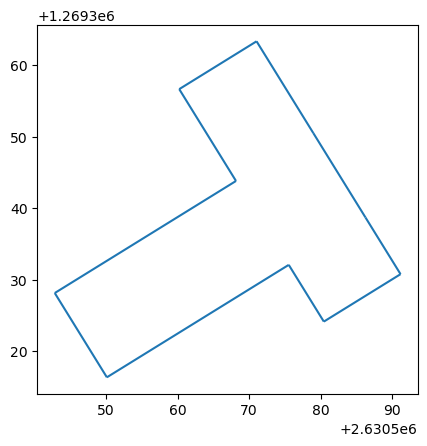

In [18]:
sample_building.geometry.plot()

To find the area of these shapes, we cannot simply call the area property of the entire table - it returns the area of each individual element, which in this case is a line, and hance it has an area equal to 0.

In [19]:
sample_building.geometry.area

575    0.0
576    0.0
577    0.0
578    0.0
579    0.0
580    0.0
581    0.0
582    0.0
583    0.0
584    0.0
dtype: float64

In [20]:
merged_line = ops.linemerge([multy.geoms[0] for multy in sample_building.geometry.values])

What's more, even if we merge the lines, they are not ordered, and no closed shape can be constructed, so no area can be calculated.

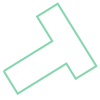

In [21]:
merged_line

In [22]:
merged_line.area

0.0

Since we know that each multiline string is a linear segment, we can get its start and end points as follows

In [23]:
[[multy.geoms[0].coords[0], multy.geoms[-1].coords[1]] for multy in sample_building.geometry.values]

[[(2630575.5309999995, 1269332.0870000012),
  (2630550.0929999985, 1269316.357999999)],
 [(2630550.0929999985, 1269316.357999999),
  (2630542.8040000014, 1269328.1460000016)],
 [(2630542.8040000014, 1269328.1460000016),
  (2630568.153999999, 1269343.8209999986)],
 [(2630578.971999999, 1269350.511), (2630586.261, 1269338.7210000008)],
 [(2630568.153999999, 1269343.8209999986),
  (2630560.2140000015, 1269356.6640000008)],
 [(2630560.2140000015, 1269356.6640000008),
  (2630571.030000001, 1269363.3539999984)],
 [(2630571.030000001, 1269363.3539999984), (2630578.971999999, 1269350.511)],
 [(2630586.261, 1269338.7210000008), (2630591.1689999998, 1269330.7850000001)],
 [(2630591.1689999998, 1269330.7850000001),
  (2630580.4389999993, 1269324.1499999985)],
 [(2630580.4389999993, 1269324.1499999985),
  (2630575.5309999995, 1269332.0870000012)]]

Now we need to sort the pairs of points in order to get the polygons area. One way to do this is to use a dictionary with tupples as keys.

In [24]:
segments = {}
for multy in sample_building.geometry.values:
    start = multy.geoms[0].coords[0]
    end = multy.geoms[0].coords[-1]
    if start in segments.keys():
        continue
    segments[start] = end
segments

{(2630575.5309999995, 1269332.0870000012): (2630550.0929999985,
  1269316.357999999),
 (2630550.0929999985, 1269316.357999999): (2630542.8040000014,
  1269328.1460000016),
 (2630542.8040000014, 1269328.1460000016): (2630568.153999999,
  1269343.8209999986),
 (2630578.971999999, 1269350.511): (2630586.261, 1269338.7210000008),
 (2630568.153999999, 1269343.8209999986): (2630560.2140000015,
  1269356.6640000008),
 (2630560.2140000015, 1269356.6640000008): (2630571.030000001,
  1269363.3539999984),
 (2630571.030000001, 1269363.3539999984): (2630578.971999999, 1269350.511),
 (2630586.261, 1269338.7210000008): (2630591.1689999998, 1269330.7850000001),
 (2630591.1689999998, 1269330.7850000001): (2630580.4389999993,
  1269324.1499999985),
 (2630580.4389999993, 1269324.1499999985): (2630575.5309999995,
  1269332.0870000012)}

In [25]:
remaining_points = list(segments.keys())
polygons = []
found_points = []
joined_polygons = None

while len(remaining_points) > 1:
    sorted_points = []
    start = remaining_points[0]
    end = ''
    while end != remaining_points[0] and start not in sorted_points:
        if start not in segments.keys():
            break
        end = segments[start]
        sorted_points.append(start)
        start = segments[start]
    sorted_points.append(start)
    found_points += sorted_points
    remaining_points = list(
        set(list(segments.keys())).difference(set(found_points)))
    if (len(sorted_points) < 3):
        continue
    sample_building_footprint = Polygon(sorted_points)
    
    if joined_polygons is None:
        joined_polygons = sample_building_footprint
    polygons.append(sample_building_footprint)
    joined_polygons = joined_polygons.union(sample_building_footprint)

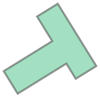

In [26]:
joined_polygons

In [27]:
joined_polygons.area

899.1466259645487

In [28]:
polygons[0].area, polygons[0].length

(899.1466259645485, 161.62959488774484)

Now that we have figured out how to extract footprint geometry lines, sort them, join them into separate closed polygons, and calculate their total area and perimeter, we can apply this to the entire dataset.

In [29]:
def calculate_area(group):

    segments = {}

    segments = {}
    for multy in group.geometry.values:
        start = multy.geoms[0].coords[0]
        end = multy.geoms[0].coords[-1]
        if start in segments.keys():
            continue
        segments[start] = end
    segments

    remaining_points = list(segments.keys())
    found_points = []
    joined_polygons = None
    
    while len(remaining_points) > 1:
        sorted_points = []
        start = remaining_points[0]
        end = ''
        while end != remaining_points[0] and start not in sorted_points:
            if start not in segments.keys():
                break
            end = segments[start]
            sorted_points.append(start)
            start = segments[start]
        sorted_points.append(start)

        found_points += sorted_points
        remaining_points = list(
            set(list(segments.keys())).difference(set(found_points)))

        if (len(sorted_points) < 3):
            continue

        sample_building_footprint = Polygon(sorted_points)

        if sample_building_footprint.is_valid == False:
            continue
        if joined_polygons is None:
            joined_polygons = sample_building_footprint
        polygons.append(sample_building_footprint)
        joined_polygons = joined_polygons.union(sample_building_footprint)

    row_dict = {}
    row_dict['area'] = joined_polygons.length if joined_polygons is not None else 0
    row_dict['perimeter'] = joined_polygons.area if joined_polygons is not None else 0
    row_dict['polygons'] = joined_polygons


    return pd.Series(row_dict)


areas = gdf.groupby('GWR_EGID', as_index=False).apply(
    calculate_area).rename(columns={'GWR_EGID': 'Id'})

In [30]:
areas.head()

,Id,area,perimeter,polygons
0,8267,50.684752,111.944161,POLYGON ((2688342.4959999993 1280219.614999998...
1,9089,45.436243,90.748115,"POLYGON ((2691008.8159999996 1282772.886, 2691..."
2,9232,51.882385,137.947371,POLYGON ((2691485.789999999 1282327.6719999984...
3,9696,59.397324,149.386657,POLYGON ((2689478.3139999993 1282186.035000000...
4,11139,58.814565,160.838809,POLYGON ((2689363.0139999986 1280924.875999998...


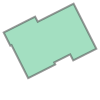

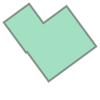

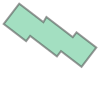

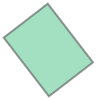

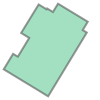

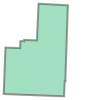

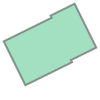

In [31]:
# one polygon building footprint
display(areas.iloc[47].polygons)
display(areas.iloc[79].polygons)
display(areas.iloc[152].polygons)
display(areas.iloc[164].polygons)
display(areas.iloc[239].polygons)
display(areas.iloc[52].polygons)
display(areas.iloc[355].polygons)

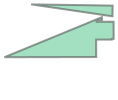

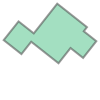

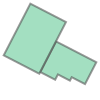

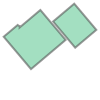

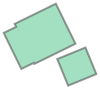

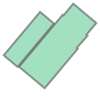

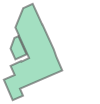

In [32]:
# multiple polygon building footprint
display(areas.iloc[42].polygons)
display(areas.iloc[78].polygons)
display(areas.iloc[102].polygons)
display(areas.iloc[154].polygons)
display(areas.iloc[229].polygons)
display(areas.iloc[51].polygons)
display(areas.iloc[325].polygons)

At first all looks good, however some polygons have not been partitioned very well. (A better approach is needed here.)

457818

2

shapely.geometry.multipolygon.MultiPolygon

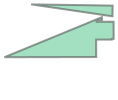

In [33]:
display(areas.iloc[42]['Id'])
display(len(areas.iloc[42].polygons.geoms))
display(type(areas.iloc[42].polygons))
display(areas.iloc[42].polygons)


In [34]:
areas.shape

(1836, 4)

Lets keep only the building geometries that consist only of one polygon.

In [35]:
import shapely
cleaned_areas = areas[areas['polygons'].apply(lambda x: type(x) == shapely.geometry.polygon.Polygon)]
cleaned_areas.shape

(1765, 4)

We observe that we have less data about building geometry compared to what we have from the building register. Lets do an inner merge of the two datasets.

In [36]:
buildings_filtered.shape

(1998, 15)

In [37]:
df_merged = pd.merge(cleaned_areas, buildings_filtered, right_on=['Id'], left_on=['Id'], how='inner').drop(columns='polygons')
df_merged.head()

,Id,area,perimeter,municipality,address,canton,status,category,class,year,stories,certificate,standard,longitude_ch,latitude_ch,energy,ERFA
0,8267,50.684752,111.944161,Dachsen,Bahnhofstrasse 4,ZH,1004,1020,1110.0,1846.0,2.0,ZH-3248,Minergie,688346.0,280218.0,7540.0,231
1,9089,45.436243,90.748115,Feuerthalen,Scheibenäckerstrasse 6,ZH,1004,1020,1110.0,1956.0,3.0,ZH-208-P,Minergie_P,691016.0,282780.0,7598.0,281
2,9232,51.882385,137.947371,Feuerthalen,Kirchweg 134,ZH,1004,1020,1110.0,1952.0,2.0,ZH-7089,Minergie,691483.0,282339.0,7598.0,187
3,9696,59.397324,149.386657,Flurlingen,Hallauerweg 8,ZH,1004,1020,1110.0,1973.0,2.0,ZH-5037,Minergie,689475.0,282189.0,7530.0,178
4,11139,58.814565,160.838809,Laufen-Uhwiesen,Schulstrasse 37,ZH,1004,1020,1110.0,1968.0,2.0,ZH-394,Minergie,689374.0,280936.0,7530.0,263


In [38]:
df_merged.shape

(1553, 17)

In [39]:
# clean missing values
df_clean = df_merged[(df_merged['stories'].isna() == False) & (df_merged['year'].isna() == False)]
df_clean.shape

(1414, 17)

<Axes: >

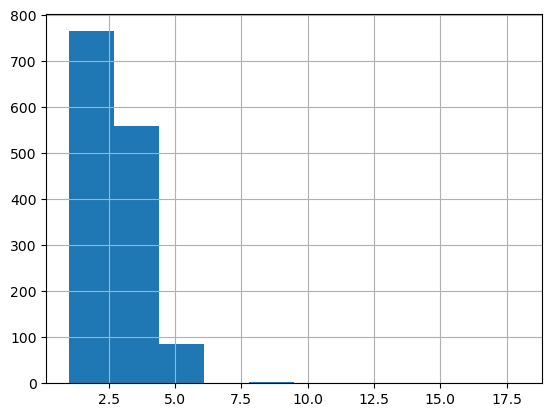

In [40]:
df_clean['stories'].hist()

In [41]:
initial_data = df_clean[['area','perimeter', 'stories', 'ERFA']].astype(float)
initial_data.head()

,area,perimeter,stories,ERFA
0,50.684752,111.944161,2.0,231.0
1,45.436243,90.748115,3.0,281.0
2,51.882385,137.947371,2.0,187.0
3,59.397324,149.386657,2.0,178.0
4,58.814565,160.838809,2.0,263.0


In [42]:
data = initial_data.copy()
data.insert(1, "gross_area", initial_data['area'] * initial_data['stories'])
data.head()

,area,gross_area,perimeter,stories,ERFA
0,50.684752,101.369504,111.944161,2.0,231.0
1,45.436243,136.308728,90.748115,3.0,281.0
2,51.882385,103.764769,137.947371,2.0,187.0
3,59.397324,118.794647,149.386657,2.0,178.0
4,58.814565,117.629131,160.838809,2.0,263.0


<Axes: xlabel='ERFA', ylabel='Count'>

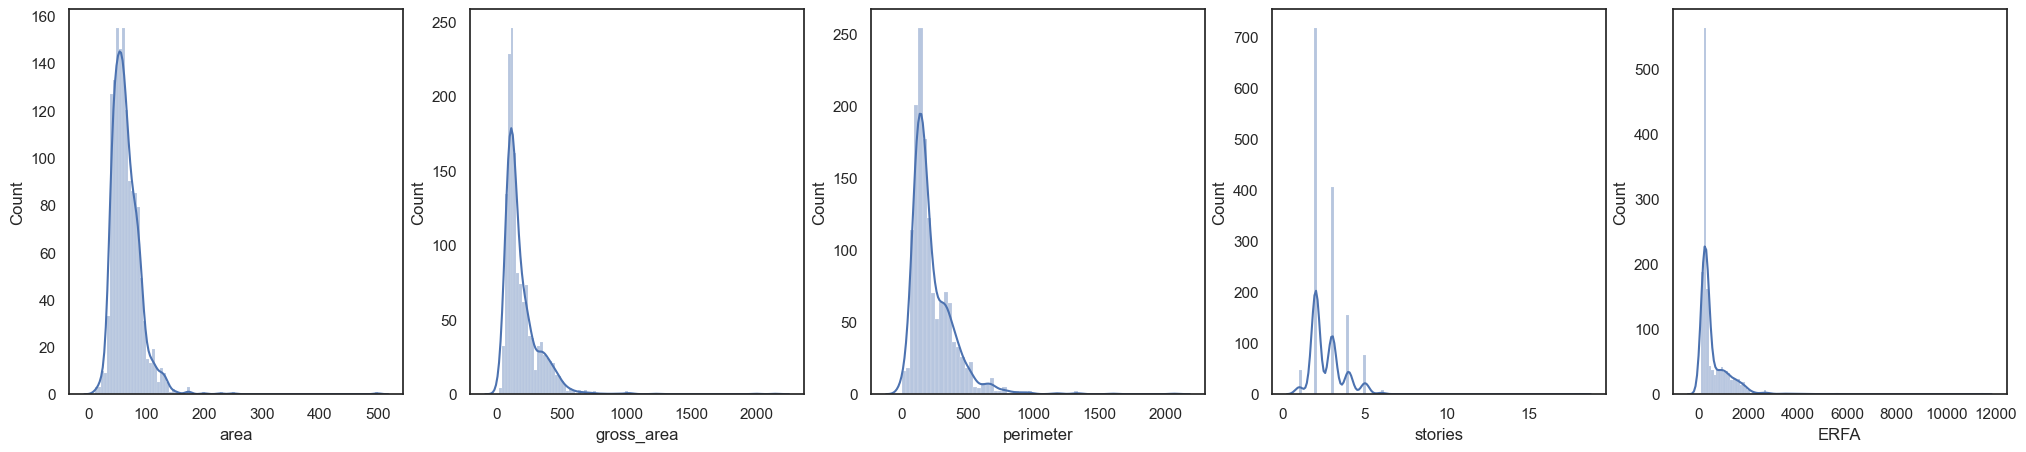

In [53]:
import warnings
warnings.filterwarnings('ignore')


fig, axs = plt.subplots(ncols=5, figsize=(25, 5))

sns.histplot(
    data.area, kde=True,
    stat="count", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),ax=axs[0]
)

sns.histplot(
    data.gross_area, kde=True,
    stat="count", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),ax=axs[1]
)

sns.histplot(
    data.perimeter, kde=True,
    stat="count", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),ax=axs[2]
)

sns.histplot(
    data.stories, kde=True,
    stat="count", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),ax=axs[3]
)

sns.histplot(
    data.ERFA, kde=True,
    stat="count", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),ax=axs[4]
)

We see that there are some outlier datapoints. Lets remove them and see if we get a better relationship.

[Text(0.5, 0, 'ERFA')]

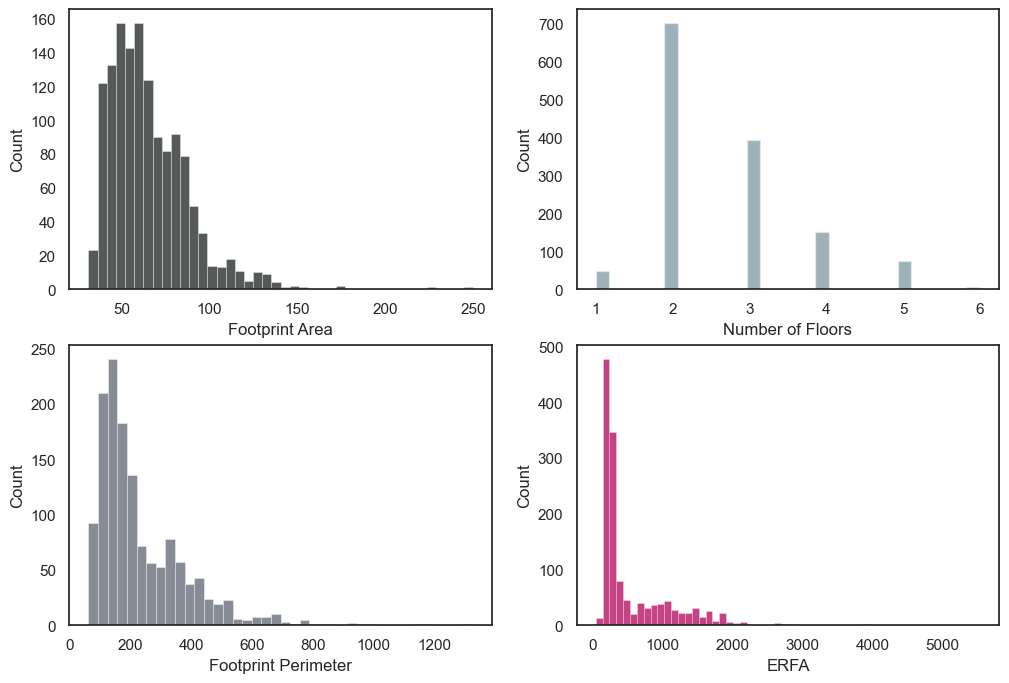

In [54]:
import warnings
warnings.filterwarnings('ignore')


cut_data = data[(data.area > 30) & (data.ERFA > 40) & (data.perimeter > 50) & (data.gross_area < 1000)]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))

sns.histplot(
    cut_data.area, kde=False,
    stat="count", kde_kws=dict(cut=3),
    color='#1c2321',
    edgecolor=(1, 1, 1, .4),ax=axs[0,0]
)

axs[0,0].set(xlabel='Footprint Area')

sns.histplot(
    cut_data.stories, kde=False,
    stat="count", kde_kws=dict(cut=3),
    color="#7d98a1",
    edgecolor=(1, 1, 1, .4),ax=axs[0,1]
)

axs[0,1].set(xlabel='Number of Floors')

sns.histplot(
    cut_data.perimeter, kde=False,
    stat="count", kde_kws=dict(cut=3),
    color="#5e6572",
    edgecolor=(1, 1, 1, .4),ax=axs[1,0]
)

axs[1,0].set(xlabel='Footprint Perimeter')

sns.histplot(
    cut_data.ERFA, kde=False,
    stat="count", kde_kws=dict(cut=3),
    color="#B4045A",
    edgecolor=(1, 1, 1, .4),ax=axs[1,1]
)

axs[1,1].set(xlabel='ERFA')

In [45]:
cut_data.shape

(1378, 5)

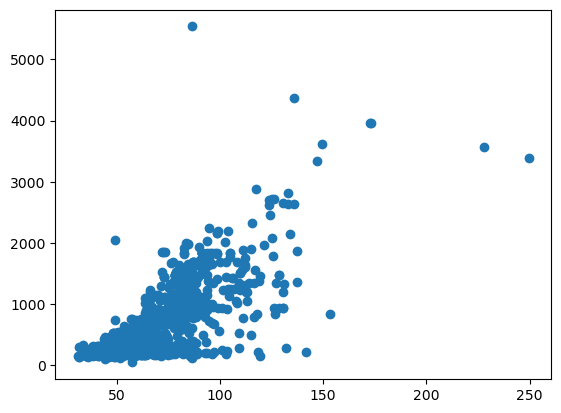

In [46]:
plt.scatter(cut_data.area, cut_data.ERFA)

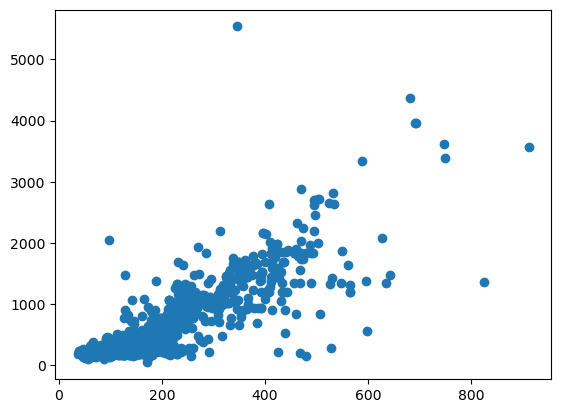

In [47]:
plt.scatter(cut_data.gross_area, cut_data.ERFA)

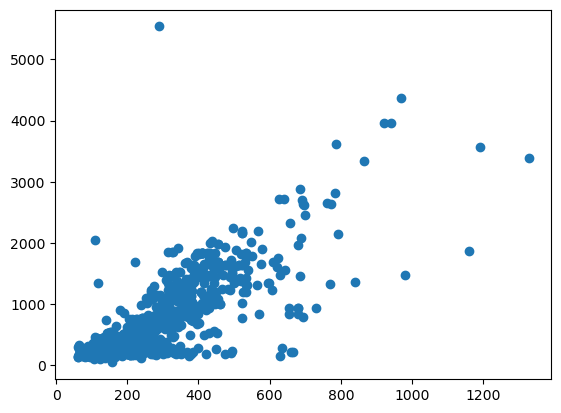

In [48]:
plt.scatter(cut_data.perimeter, cut_data.ERFA)

Lets remove outliers so our prediction would be more precise.

<Axes: >

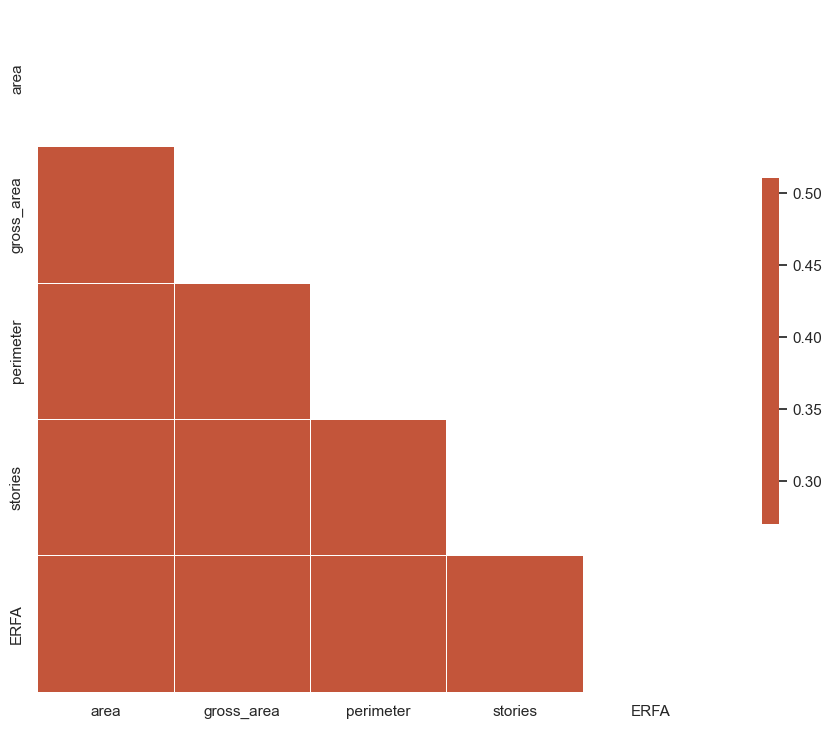

In [49]:
sns.set_theme(style="white")


# Compute the correlation matrix
corr = cut_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [50]:
from sklearn import linear_model 
from sklearn.metrics import mean_squared_error, r2_score


data_train = cut_data.iloc[:-100]
data_test = cut_data.iloc[-100:]
last = data_train.shape[1] - 1

#Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(data_train.iloc[:,0:last], data_train.iloc[:,last])


# Make predictions using the testing set
y_pred = np.round(regr.predict(data_test.iloc[:,:last]))

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(data_test.iloc[:,[last]], y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(data_test.ERFA, y_pred))


Coefficients: 
 [-13.57789286   3.93211606   2.5583997  -71.27600963]
Mean squared error: 69972.78
Coefficient of determination: 0.80


In [51]:
y = data_test.ERFA.to_numpy()
X = data_train.iloc[:,0:last]

SS_Residual = sum((y-y_pred)**2)       
SS_Total = sum((y-np.mean(y))**2)     
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
print (r_squared, adjusted_r_squared)

0.8028928376744138 0.7945935887343891


Although we obtained a relatively good R-squared value, the MSE is much too high.

In [52]:
y, y_pred

(array([ 250.,  342.,  858.,  315., 1147.,  174.,  174.,  174.,  174.,
         174.,  174.,  174.,  174.,  227.,  182.,  182.,  182.,  182.,
         182., 3381., 1638., 1638., 1638., 1638., 1638., 1638., 1638.,
        1638.,  216., 1638.,  280.,  216.,  250.,  209.,  200., 2050.,
         209., 1196.,  242., 1059., 1059.,  220.,  179.,  172.,  260.,
         240.,  896., 1088.,  378.,  307.,  234.,  241.,  162., 1222.,
         151.,  277.,  181.,  200.,  199.,  387.,  300.,  178.,  939.,
        1034.,  209.,  177.,  179., 1196., 1196.,  421.,  824.,  179.,
         363.,  187., 1687.,  180.,  255.,  277.,  758.,  758.,  293.,
         237.,  324.,  342.,  242.,  223.,  416.,  366.,  135.,  266.,
        1457.,  253.,  206.,  322., 1446.,  190., 1196.,  445., 1382.,
         200.]),
 array([ 257.,  367.,  737.,  241., 1006.,  384.,  542.,  382.,  530.,
         549.,  532.,  697.,  534.,  239.,  181.,  151.,  181.,  152.,
         152., 3058., 1548., 1489., 1447., 1459., 1573., 144

#### Conclusion

Although we visually observed that there is a relationship between the selected variables, additional factors should be added and more data would be needed to build a better model.